Reference
---------
- [RF in Python](https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f)
- [Tracking OOB errors](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)
   - Demonstrates how the OOB error can be measured at the addition of each new tree during training. The resulting plot allows a practitioner to approximate a suitable value of n_estimators at which the error stabilizes.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import pandas as pd
from pandas import DataFrame
import os, sys

# Tensorflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
# tf.executing_eagerly()

# Colab 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Plotting
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
import seaborn as sns
from IPython.display import display

from tqdm import tqdm

### Configure system environment
- Please modify `input_dir` according to your local enviornment

In [2]:
cur_dir = os.getcwd()
project_dir = 'machine_learning_examples'
if IN_COLAB: 
    # Run this demo on Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Parameters for data
    input_dir = f"/content/drive/MyDrive/Colab Notebooks/{project_dir}/data/data-is-life"
    # /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life

    sys.path.append(input_dir)
else: 
    input_dir = cur_dir
    
if input_dir != cur_dir: 
    sys.path.append(input_dir)
    print(f"> Adding {input_dir} to sys path ...")
    print(sys.path)

# Import user libraries
# import utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
> Adding /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life to sys path ...
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life']


### Load data

In [3]:
# The `exit_status` here is the response variable
assert os.path.exists(input_dir), "Try restarting the kernel :)"

input_path = os.path.join(input_dir, 'train.csv')
df_train = pd.read_csv(input_path)
print(f"> Shape(df_train): {df_train.shape}")
display(df_train.head())

> Shape(df_train): (2600, 17)


,id,gender,age,dependents,lifetime,phone_services,internet_services,online_streaming,multiple_connections,premium_plan,online_protect,contract_plan,ebill_services,default_payment,monthly_charges,issues,exit_status
0,1689,Male,30-45,Yes,7,No,3G,Major User,NaN,No,Yes,Month-to-month,No,Physical,58.85,2,No
1,794,Female,18-30,No,6,No,3G,Major User,NaN,No,No,Month-to-month,No,Auto-payment,45.00,6,No
2,4211,Male,>60,No,24,Yes,4G,Major User,Yes,No,Yes,Month-to-month,Yes,Auto-payment,102.95,22,Yes
3,3318,Male,18-30,No,10,No,3G,No,NaN,No,Yes,Month-to-month,No,Physical,29.50,28,Yes
4,5245,Female,30-45,Yes,70,Yes,NaN,NaN,No,NaN,NaN,Two year,Yes,Auto-payment,20.15,13,No


### EDA 

In [4]:
# Check null values

df_train.isnull().sum()

id                        0
gender                    0
age                       0
dependents                0
lifetime                  0
phone_services            0
internet_services       259
online_streaming        458
multiple_connections    241
premium_plan            458
online_protect          458
contract_plan             0
ebill_services            0
default_payment           0
monthly_charges           0
issues                    0
exit_status               0
dtype: int64

In [5]:
# Check null values in the test set 
input_file = 'test.csv'
input_path = os.path.join(input_dir, input_file)
df_test = pd.read_csv(input_path)
display(df_test.isnull().sum())

id                        0
gender                    0
age                       0
dependents                0
lifetime                  0
phone_services            0
internet_services       143
online_streaming        224
multiple_connections    129
premium_plan            224
online_protect          224
contract_plan             0
ebill_services            0
default_payment           0
monthly_charges           0
issues                    0
dtype: int64

As expected, there are NAs in `test.csv`. Hence, we will treat NAs as a category and assume it contributes to the response variable `exit_status`.

### Encode variables

In [6]:
# replace Yes and No in the label column (exit_status)

exit_status_map = {'Yes': 1, 'No': 0}
df_train['exit_status'] = df_train['exit_status'].map(exit_status_map) # map a dictionary

In [7]:
# split into X and y 

y = df_train.pop('exit_status') # this pop() operation alters the dataframe
# ... y is a Series
# ... y = df_train['exit_status']; df_train.drop('exit_status', axis=1)
X = df_train.drop('id', axis = 1) # 'id' is not useful for predicting exit status
print(f"> Shape(X): {X.shape}")

> Shape(X): (2600, 15)


### Create training and validation sets

In [8]:
from sklearn.model_selection import train_test_split

seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state = seed)


### Identify & Encode categorical variables

In [9]:
# fill NaN with a string, say, 'na'

X_train = X_train.fillna('na')
X_test = X_test.fillna('na')

In [10]:
# Categorical variables are of "object" type
X_train.dtypes

gender                   object
age                      object
dependents               object
lifetime                  int64
phone_services           object
internet_services        object
online_streaming         object
multiple_connections     object
premium_plan             object
online_protect           object
contract_plan            object
ebill_services           object
default_payment          object
monthly_charges         float64
issues                    int64
dtype: object

In [11]:
features_to_encode = list(X_train.select_dtypes(include = ['object']).columns) 

# Or alternatively, 
# features_to_encode = X_train.columns[X_train.dtypes==object].tolist()  
print(features_to_encode)

['gender', 'age', 'dependents', 'phone_services', 'internet_services', 'online_streaming', 'multiple_connections', 'premium_plan', 'online_protect', 'contract_plan', 'ebill_services', 'default_payment']


In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
col_trans = make_column_transformer(
                        (OneHotEncoder(), features_to_encode),
                        remainder = "passthrough" # [1]
                        )
# This constructor will automatically handle the categorical variables and leave numeric variables untouched

# [1] The remainder = 'passthrough' allows the constructor to ignore those variables that are not included in features_to_encode

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=seed,
                      max_features='auto')

# NOTE: I would recommend to always start with the model where oob_score = True 
#       because it is better to use out-of-bag samples to estimate the generalization accuracy

In [14]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(col_trans, rf_classifier) # apply the transformer on the classifier

`pipe` is a new black box created with 2 components: 
1. A constructor to handle inputs with categorical variables and transform into a correct type, and 
2. A classifier that receives those newly transformed inputs from the constructor.

In [15]:
pipe.fit(X_train, y_train)

print(X_train.shape) # X: 2D vector
print(y_train.shape) # y: 1D vector

(1734, 15)
(1734,)


In [16]:
y_pred = pipe.predict(X_test)

### Evaluate the classifier

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

In [18]:
accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")

The accuracy of the model is 91.10000000000001 %


#### Make probablistic predictions

In [19]:
train_probs = pipe.predict_proba(X_train)[:,1] # <<< how well does the model fits the training data
probs = pipe.predict_proba(X_test)[:, 1] # <<< as compared to how well the model fits the test data 
train_predictions = pipe.predict(X_train)

# NOTE: predict_proba(dataframe)[:,1] gives the predicted probability distribution of class label 1 from the dataframe.

In [20]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.9678578659647703
Test ROC AUC  Score: 0.967591183178179


Recall                  Baseline: 1.0                  Test: 0.92                  Train: 0.93
Precision                  Baseline: 0.48                  Test: 0.9                  Train: 0.91
Roc                  Baseline: 0.5                  Test: 0.97                  Train: 0.97


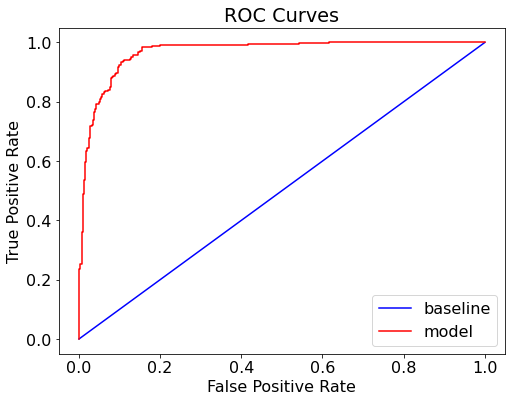

In [21]:
def evaluate_model(y_pred, probs, train_predictions, train_probs):
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5

    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)

    train_results = {}
    train_results['recall'] = recall_score(y_train,       train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)

    for metric in ['recall', 'precision', 'roc']:  
          print(f'{metric.capitalize()} \
                 Baseline: {round(baseline[metric], 2)} \
                 Test: {round(results[metric], 2)} \
                 Train: {round(train_results[metric], 2)}')

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

################################

evaluate_model(y_pred, probs, train_predictions, train_probs)

# Recall Baseline: 1.0 Test: 0.92 Train: 0.93 
# Precision Baseline: 0.48 Test: 0.9 Train: 0.91 
# Roc Baseline: 0.5 Test: 0.97 Train: 0.97

#### Confusion matrix

In [22]:
import itertools

def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

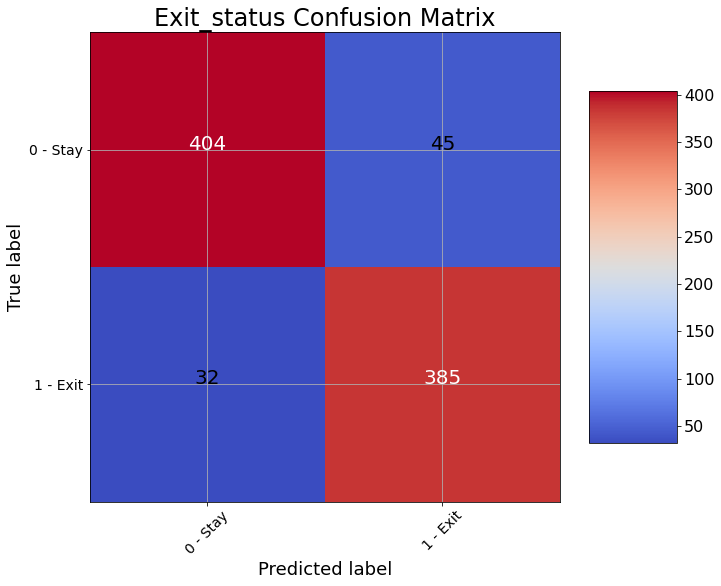

In [23]:
# Let's plot it out
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - Stay', '1 - Exit'],
                      title = 'Exit_status Confusion Matrix', cmap='coolwarm')


#### Feature Importance

In [24]:
print(rf_classifier.feature_importances_)
print(f" There are {len(rf_classifier.feature_importances_)} features in total")

print() 
print(f"> shape(X_train): {X_train.shape}, shape(X_test): {X_test.shape}, n_features={X_train.shape[1]}")

[7.41626071e-04 6.12165359e-04 1.42322746e-03 6.93254520e-03
 2.93650843e-04 1.96706074e-04 1.85830433e-03 2.67517842e-03
 1.02110066e-05 2.99006245e-05 6.15325794e-03 1.66647237e-02
 4.49100748e-03 3.37963818e-05 1.87449830e-03 1.00225588e-03
 3.72119245e-04 1.39558189e-02 8.28073088e-04 3.41692010e-04
 1.71733193e-04 7.60943914e-02 1.09485070e-02 1.78380970e-02
 1.63392715e-02 2.93397339e-03 1.46445733e-02 1.34849432e-01
 1.33144331e-02 4.42753783e-02 3.13204793e-03 4.97894324e-03
 6.17692498e-03 2.70959923e-02 1.61849449e-03 7.57024010e-02
 2.31468190e-02 4.66247828e-01]
 There are 38 features in total

> shape(X_train): (1734, 15), shape(X_test): (866, 15), n_features=15


There are 38 features in total. However, there are only 15 columns in X_train. This is because the model pipe automatically encodes the categorical variables in X_train. For example, the gender column in X_train is transformed into 2 columns Female and Male.
- `col_trans.fit_transform(X_train)` will give the encoded `X_train` 

In [25]:
# col_trans.fit_transform(X_train) will give the encoded X_train

# Let's look at the first row
print(col_trans.fit_transform(X_train)[0,:])

# And the first row of X_train
X_train.iloc[0,:]  

[ 0.    1.    0.    0.    0.    1.    1.    0.    0.    1.    1.    0.
  0.    0.    1.    0.    0.    0.    1.    0.    0.    1.    0.    0.
  1.    0.    0.    1.    0.    0.    0.    1.    0.    1.    0.   30.
 74.75 14.  ]


gender                             Male
age                                 >60
dependents                           No
lifetime                             30
phone_services                      Yes
internet_services                    3G
online_streaming             Major User
multiple_connections                 No
premium_plan                         No
online_protect                       No
contract_plan            Month-to-month
ebill_services                      Yes
default_payment         Online Transfer
monthly_charges                   74.75
issues                               14
Name: 1258, dtype: object

For X_train, there are 3 numeric variables, with values being 30, 70.75 and 14 respectively. For the encoded X_train, these 3 numeric values are placed after all the categorical variables

#### Create a proper encoded X_train

In [26]:
def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)

In [27]:
X_train_encoded = encode_and_bind(X_train, features_to_encode) 
display(X_train_encoded.head(8))

print(f'shape(X_train_encoded): {X_train_encoded.shape}')

,gender_Female,gender_Male,age_18-30,age_30-45,age_45-60,age_>60,dependents_No,dependents_Yes,phone_services_No,phone_services_Yes,internet_services_3G,internet_services_4G,internet_services_None,internet_services_na,online_streaming_Major User,online_streaming_No,online_streaming_Sometimes,online_streaming_na,multiple_connections_No,multiple_connections_Yes,multiple_connections_na,premium_plan_No,premium_plan_Yes,premium_plan_na,online_protect_No,online_protect_Yes,online_protect_na,contract_plan_Month-to-month,contract_plan_One year,contract_plan_Two year,ebill_services_No,ebill_services_Yes,default_payment_Auto-payment,default_payment_Online Transfer,default_payment_Physical,lifetime,monthly_charges,issues
1258,0,1,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,30,74.75,14
1812,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,23,20.05,6
270,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,61,89.20,5
1807,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,24,21.10,10
1113,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,2,70.65,23
928,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,45.95,15
668,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,28,104.80,28
2048,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,5,67.95,19


shape(X_train_encoded): (1734, 38)


#### [Q] How do we know that the feature ordering is consistent? 

In [28]:
feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

Feature: issues                              Importance: 0.46624782846326046
Feature: contract_plan_Month-to-month        Importance: 0.1348494321203859
Feature: premium_plan_No                     Importance: 0.07609439137797289
Feature: lifetime                            Importance: 0.07570240099772282
Feature: contract_plan_Two year              Importance: 0.04427537832458953
Feature: default_payment_Online Transfer     Importance: 0.027095992311968936
Feature: monthly_charges                     Importance: 0.023146819033694803
Feature: premium_plan_na                     Importance: 0.01783809701516951
Feature: internet_services_4G                Importance: 0.016664723657875163
Feature: online_protect_No                   Importance: 0.01633927147353242
Feature: online_protect_na                   Importance: 0.014644573293332979
Feature: online_streaming_na                 Importance: 0.013955818858399235
Feature: contract_plan_One year              Importance: 0.0133144331397

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


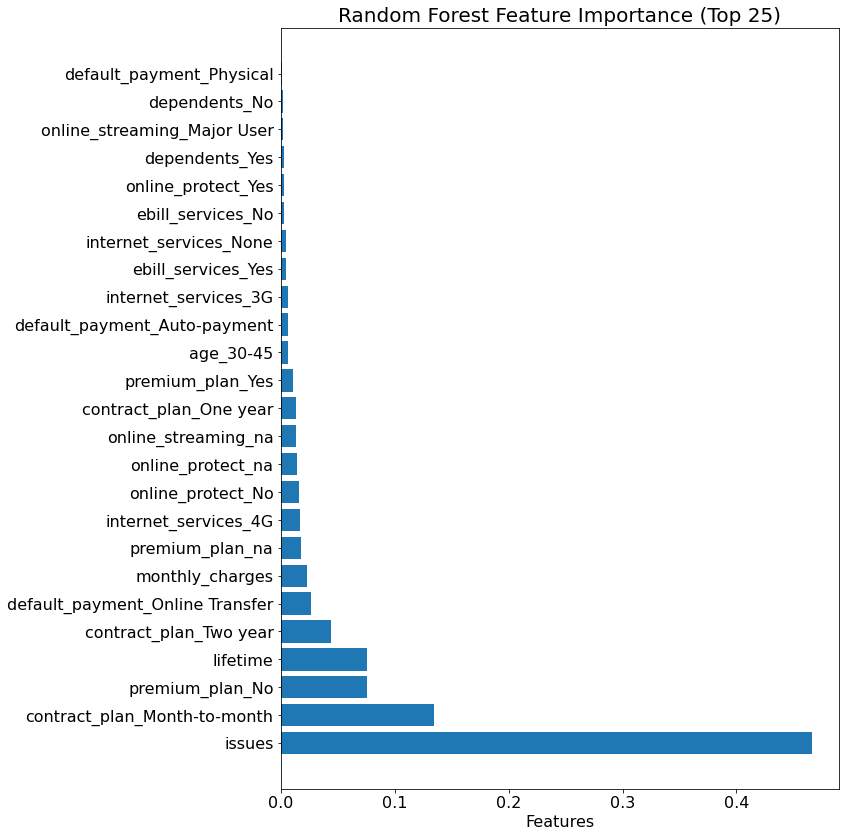

In [29]:
# Plot the top N feature importance
topn = 25
feature_names = [i[0] for i in feature_importances_ranked[:topn]]
y_ticks = np.arange(0, len(feature_names))
x_axis = [i[1] for i in feature_importances_ranked[:topn]]
plt.figure(figsize = (10, 14))

plt.barh(feature_names, x_axis)   #horizontal barplot
plt.title(f'Random Forest Feature Importance (Top {topn})',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

### Model Selection: Tune the hyperparameters with RandomSearchCV

In [30]:
# Current parameters

from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf_classifier.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 50,
 'verbose': 0,
 'warm_start': False}


### Grid search

Define parameter grid 
- np.linespace

In [31]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node

bootstrap = [True, False]       # Method of selecting samples for training each tree
# ... NOTE: Out of bag estimation only available if bootstrap=True

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)), # 10 to 50 "inclusive"
               'bootstrap': bootstrap}

In [32]:
# Create base model to tune
rf = RandomForestClassifier(oob_score=True)

# Create random search model and fit the data
rf_random = RandomizedSearchCV(
                        estimator = rf,
                        param_distributions = random_grid,
                        n_iter = 100, cv = 3,
                        verbose=2, random_state=seed, 
                        scoring='roc_auc')
# ... First create a base model, then use random grid to select the best model, 
# ... based on the ROC_AUC score, hence scoring = 'roc_auc'

rf_random.fit(X_train_encoded, y_train)
rf_random.best_params_

# Result
# 
candidate_best_params_ = \
    {'bootstrap': True,
    'max_depth': 100,
    'max_features': 'auto',
    'max_leaf_nodes': 46,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 565}

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=110, max_features=log2, max_leaf_nodes=49, min_samples_leaf=4, min_samples_split=5, n_estimators=565; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=log2, max_leaf_nodes=49, min_samples_leaf=4, min_samples_split=5, n_estimators=565; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=log2, max_leaf_nodes=49, min_samples_leaf=4, min_samples_split=5, n_estimators=565; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_nodes=14, min_samples_leaf=1, min_samples_split=2, n_estimators=467; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_nodes=14, min_samples_leaf=1, min_samples_split=2, n_estimators=467; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_nodes=14, min_samples_leaf=1, min_samples_split=2, n_estimators=467; total time=   1.1s
[

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 411, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib

In [33]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
rf_random = RandomizedSearchCV(
                estimator = rf,
                param_distributions = random_grid,
                n_iter = 50, cv = 3,
                verbose=1, random_state=seed,
                scoring='roc_auc')
pipe_random = make_pipeline(col_trans, rf_random)
pipe_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
78 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 411, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/p

{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'max_leaf_nodes': 39,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'n_estimators': 148}

In [34]:
# Pretend that best parameters are known 
# candidate_best_params = \
#     {'bootstrap': True,
#     'max_depth': 100,
#     'max_features': 'auto',
#     'max_leaf_nodes': 46,
#     'min_samples_leaf': 1,
#     'min_samples_split': 10,
#     'n_estimators': 565}

# rf = RandomForestClassifier(oob_score=True)
# rf.set_params(**candidate_best_params)
# best_model = rf

# Use the best model after tuning
best_model = rf_random.best_estimator_
pipe_best_model = make_pipeline(col_trans, best_model)
pipe_best_model.fit(X_train, y_train)
y_pred_best_model = pipe_best_model.predict(X_test)

In [35]:
# To look at nodes and depths of trees use on average
n_nodes = []
max_depths = []
for ind_tree in best_model.estimators_: # <<< inspect each tree (best model has to be a CV wrapper) [1]
       n_nodes.append(ind_tree.tree_.node_count)
       max_depths.append(ind_tree.tree_.max_depth)
print(f'Average number of nodes {int(np.mean(n_nodes))}')   
print(f'Average maximum depth {int(np.mean(max_depths))}')  

# Average number of nodes 82 
# Average maximum depth 9

# NOTE 
# [1] 'RandomForestClassifier' object has no attribute 'estimators_'

Average number of nodes 75
Average maximum depth 9


### Given the best model ... 

Recall                  Baseline: 1.0                  Test: 0.93                  Train: 0.95
Precision                  Baseline: 0.48                  Test: 0.89                  Train: 0.91
Roc                  Baseline: 0.5                  Test: 0.97                  Train: 0.98


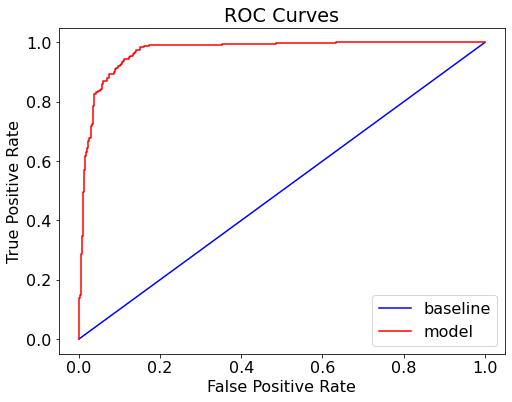

In [36]:
train_rf_predictions = pipe_best_model.predict(X_train)
train_rf_probs = pipe_best_model.predict_proba(X_train)[:, 1]
rf_probs = pipe_best_model.predict_proba(X_test)[:, 1]
# Plot ROC curve and check scores
evaluate_model(y_pred_best_model, rf_probs, train_rf_predictions, train_rf_probs)


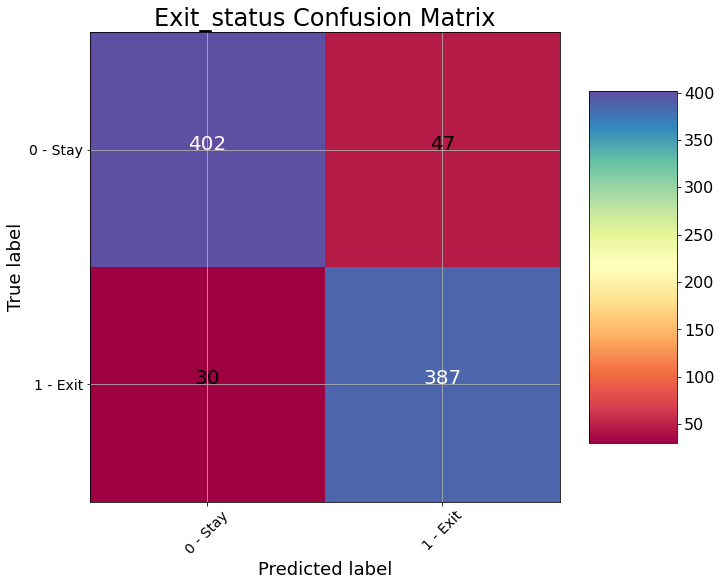

In [37]:
# Plot Confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_model), 
                      classes = ['0 - Stay', '1 - Exit'],
                      title = 'Exit_status Confusion Matrix', cmap='Spectral')

#### Use the best model to predict test set

In [38]:
input_path = os.path.join(input_dir, 'test.csv')

test = pd.read_csv(input_path)
test_withoutID = test.copy().drop('id', axis = 1) # pipe model only takes in dataframe without ID column
test_withoutID = test_withoutID.fillna('na')

final_y = pipe_best_model.predict(test_withoutID)

final_report = test
final_report['exit_status'] = final_y
final_report = final_report.loc[:,['id','exit_status']]

# Replace 1-0 with Yes-No to make it interpretable
final_report= final_report.replace(1, 'Yes')
final_report= final_report.replace(0, 'No')

In [39]:
final_report.exit_status.value_counts()

No     704
Yes    635
Name: exit_status, dtype: int64

In [40]:
output_path = os.path.join(input_dir, 'submissions.csv')
print(f"> Saving predictions at: {output_path}") 
final_report.to_csv(output_path, index=False)

> Saving predictions at: /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life/submissions.csv
